###**Criar um classificador de chamados aplicando técnicas de PLN**
---

A **DinDinAgora** tem um canal de atendimento via chat e precisa classificar os assuntos dos atendimentos para melhorar as tratativas dos chamados dos clientes. O canal recebe textos abertos dos clientes relatando o problema e/ou dúvida e depois é direcionado para algum uma área especialista no assunto para uma melhor tratativa.​

Crie um modelo classificador de assuntos aplicando técnicas de PLN, que consiga classificar através de um texto o assunto conforme disponível na base de dados [1] para treinamento e validação do modelo seu modelo.​

O modelo precisar atingir um score na **métrica F1 Score superior a 75%**. Utilize o dataset [1] para treinar e testar o modelo, separe o dataset em duas amostras (75% para treinamento e 25% para teste com o randon_state igual a 42).​

Fique à vontade para testar e explorar as técnicas de pré-processamento, abordagens de NLP, algoritmos e bibliotecas, mas explique e justifique as suas decisões durante o desenvolvimento.​

**Composição da nota:​**

**50%** - Demonstrações das aplicações das técnicas de PLN (regras, pré-processamentos, tratamentos, variedade de modelos aplicados, organização do pipeline, etc.)​

**50%** - Baseado na performance (score) obtida com a amostra de teste no pipeline do modelo campeão (validar com  a Métrica F1 Score). **Separar o pipeline completo do modelo campeão conforme template.​**

**[1] = ​https://dados-ml-pln.s3.sa-east-1.amazonaws.com/tickets_reclamacoes_classificados.csv**

Obs.: Para a métrica F1 Score, usar o parâmetro average = 'weighted'.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [4]:
import pandas as pd

df = pd.read_csv("tickets_reclamacoes_classificados.csv",sep=';')


In [2]:
df.head()

,id_reclamacao,data_abertura,categoria,descricao_reclamacao
0,3229299,2019-05-01T12:00:00-05:00,Hipotecas / Empréstimos,"Bom dia, meu nome é xxxx xxxx e agradeço se vo..."
1,3199379,2019-04-02T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...
2,3233499,2019-05-06T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,O cartão Chase foi relatado em xx/xx/2019. No ...
3,3180294,2019-03-14T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,"Em xx/xx/2018, enquanto tentava reservar um ti..."
4,3224980,2019-04-27T12:00:00-05:00,Serviços de conta bancária,"Meu neto me dê cheque por {$ 1600,00} Eu depos..."


##### Vamos verificar os tipos de categorias existentes

In [3]:
df.categoria.unique()

array(['Hipotecas / Empréstimos', 'Cartão de crédito / Cartão pré-pago',
       'Serviços de conta bancária', 'Outros',
       'Roubo / Relatório de disputa'], dtype=object)

##### Vamos verificar quantas reclamações tem em cada categoria

In [4]:
df.groupby("categoria")["descricao_reclamacao"].count()

categoria
Cartão de crédito / Cartão pré-pago    5006
Hipotecas / Empréstimos                3850
Outros                                 2233
Roubo / Relatório de disputa           4822
Serviços de conta bancária             5161
Name: descricao_reclamacao, dtype: int64

<AxesSubplot: ylabel='categoria'>

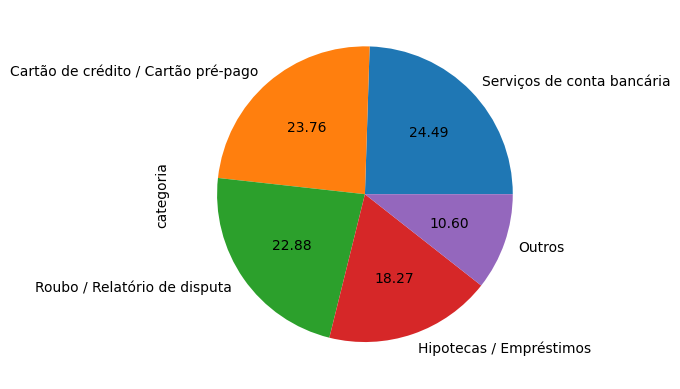

In [136]:
df['categoria'].value_counts().plot.pie(autopct='%.2f')

##### Os valores estão equilibrados de certa forma, se não conseguirmos bom resultado, provavelmente iremos equilibrar a base

##### Vamos verificar se tem algum dado em branco

In [5]:
df.descricao_reclamacao.isnull().sum()

0

In [6]:
df.descricao_reclamacao.isna().sum()

0

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
import nltk
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import unidecode
from nltk.stem.rslp import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
nltk.download('rslp')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
!pip install tensorflow
!pip install keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  Using cached protobuf-3.19.6-cp310-cp310-win_amd64.whl (895 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


ERROR: Could not install packages due to an OSError: [WinError 5] Acesso negado: 'C:\\Python310\\Lib\\site-packages\\google\\~-otobuf\\internal\\_api_implementation.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


##### Sem fazer muitas alterações, vamos tentar rodar alguns modelos estatíticos

In [18]:
def tfidvectorizer(ngram,stop_words = []):
    vect = TfidfVectorizer(ngram_range=ngram,stop_words=stop_words)
    vect.fit(df_train.descricao_reclamacao)
    return vect
def vectorizer(ngram,stop_words = []):
    vect = CountVectorizer(ngram_range=ngram,stop_words=stop_words)
    vect.fit(df_train.descricao_reclamacao)
    return vect

def rodar_modelo(vect,model):

    X_train = vect.transform(df_train.descricao_reclamacao)
    y_train = df_train["categoria"]

    model.fit(X_train, y_train)

    X_test = vect.transform(df_test.descricao_reclamacao)
    y_prediction = model.predict(X_test)

    # Verificar a accuracia
    y_test = df_test["categoria"]
    accuracy = accuracy_score(y_prediction, y_test)
    print(accuracy)


In [25]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]
df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

vecuni = vectorizer((1,1))
vecbi  = vectorizer((2,2))
vectri = vectorizer((3,3))

print("Unigrama e DecisionTreeClassifier:")
rodar_modelo(vecuni,DecisionTreeClassifier(random_state=42))
print("Bigrama e DecisionTreeClassifier:")
rodar_modelo(vecbi,DecisionTreeClassifier(random_state=42))
print("Trigrama e DecisionTreeClassifier:")
rodar_modelo(vectri,DecisionTreeClassifier(random_state=42))

print("Unigrama e LogisticRegression:")
rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))
print("Bigrama e LogisticRegression:")
rodar_modelo(vecbi,LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))
print("Trigrama e LogisticRegression:")
rodar_modelo(vectri,LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))

print("Unigrama e RandomForestClassifier:")
rodar_modelo(vecuni,RandomForestClassifier(random_state=42))
print("Bigrama e RandomForestClassifier:")
rodar_modelo(vecbi,RandomForestClassifier(random_state=42))
print("Trigrama e RandomForestClassifier:")
rodar_modelo(vectri,RandomForestClassifier(random_state=42))

#Multinomial não tem o parâmetro random_state
print("Unigrama e MultinomialNB:")
rodar_modelo(vecuni,MultinomialNB())
print("Bigrama e MultinomialNB:")
rodar_modelo(vecbi,MultinomialNB())
print("Trigrama e MultinomialNB:")
rodar_modelo(vectri,MultinomialNB())

#Multinomial não tem o parâmetro random_state
print("Unigrama e GradientBoostingClassifier:")
rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42))
print("Bigrama e GradientBoostingClassifier:")
rodar_modelo(vecbi,GradientBoostingClassifier(random_state=42))
print("Trigrama e GradientBoostingClassifier:")
rodar_modelo(vectri,GradientBoostingClassifier(random_state=42))



Unigrama e DecisionTreeClassifier:
0.7276006074411542
Bigrama e DecisionTreeClassifier:
0.6499620349278664
Trigrama e DecisionTreeClassifier:
0.5727031131359149
Unigrama e LogisticRegression:
0.8986332574031891
Bigrama e LogisticRegression:
0.8528853454821564
Trigrama e LogisticRegression:
0.7697418375094913
Unigrama e RandomForestClassifier:
0.8086560364464692
Bigrama e RandomForestClassifier:
0.7902429764616553
Trigrama e RandomForestClassifier:
0.6903948367501899
Unigrama e MultinomialNB:
0.8058086560364465
Bigrama e MultinomialNB:
0.7710706150341685
Trigrama e MultinomialNB:
0.7526575550493546
Unigrama e GradientBoostingClassifier:
0.8709187547456341
Bigrama e GradientBoostingClassifier:
0.7972665148063781
Trigrama e GradientBoostingClassifier:
0.6909643128321944


##### Agora vamos tentar tratar os dados pra ter resultados melhores

In [44]:
# iniciada uma váriavel que irá guardar as stop words
stopwords = nltk.corpus.stopwords.words('portuguese')

##### Vamos criar a função que transforma as categorias em número

In [8]:
def transformar_categorias():
    global dataset
    label_enconder = LabelEncoder()
    labels_categorias = label_enconder.fit_transform(dataset.categoria)
    dataset.categoria = labels_categorias

##### Vamos criar função que irá remover todas as sensuras dos dados

In [9]:
def remover_sensura():
    global dataset
    dataset.descricao_reclamacao = dataset.descricao_reclamacao.replace('x', '', regex=True)

##### Vamos criar uma função que irá deixar o texto todo em minusculo

In [10]:
def strlower():
    global dataset
    dataset.descricao_reclamacao = dataset.descricao_reclamacao.str.lower()

##### Vamos criar uma função que irá retirar a categoria outros

In [11]:
def retirar_outros():
    global dataset
    dataset = dataset[dataset["categoria"] != "Outros"]

##### Vamos criar uma função que irá retirar a acentuação

In [12]:
def retirar_acentuacao():
    global dataset
    dataset.descricao_reclamacao = [unidecode.unidecode(texto) for texto in dataset.descricao_reclamacao]

##### Vamos adicionar uma função que irá lematizar o texto

In [13]:
def lematize():
    global dataset
    rslp = RSLPStemmer()
    def stemmer(line):
        return ' '.join([rslp.stem(token) for token in line])
    #tokenizar o texto
    dataset.descricao_reclamacao = dataset.descricao_reclamacao.apply(word_tokenize)
    #aplicar lematize
    dataset.descricao_reclamacao = dataset.descricao_reclamacao.apply(stemmer)
    #juntar novamente as palavras
    dataset.descricao_reclamacao = [WordNetLemmatizer().lemmatize(w) for w in dataset.descricao_reclamacao]

##### Vamos adicionar uma função que irá retirar todos os caracteres especiais

In [14]:
def apenas_texto():
    global dataset
    dataset.descricao_reclamacao = dataset.descricao_reclamacao.replace('[^a-zA-Z ]', '', regex=True)

##### Vamos adicionar uma função que ira apagar todos os espaços extras no texto

In [15]:
def retirar_espacos():
    dataset.descricao_reclamacao = dataset.descricao_reclamacao.replace(' [^a-zA-Z]', '', regex=True)

##### Primeiramente vamos tentar rodar os modelos com todos os tratamentos, e utilizando somente o unigram, pois além de ser mais perfomatico, foi o que teve maior acuracia

In [73]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]

retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
retirar_espacos()
lematize()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

dataset

,categoria,descricao_reclamacao
0,1,bom dia meu nom e e agradec se voc pud me ajud...
1,0,atualiz meu carta eme fui inform pel agent que...
2,0,o carta chas foi relat emn entant o ped fraudu...
3,0,emenquant tent reserv um ticket me dep com uma...
4,3,meu net me de chequ por eu deposit o na minh c...
...,...,...
21064,2,emarquiv uma disput na minh empr de carta de c...
21066,3,meu marid falec o chas bank control o chequ el...
21067,0,depois de ser um client de carta de perseguica...
21068,2,na quart feiralig par o cha meu prov de carto ...


In [74]:
vecuni = vectorizer((1,1))

print("Unigrama e DecisionTreeClassifier:")
rodar_modelo(vecuni,DecisionTreeClassifier(random_state=42))

print("Unigrama e LogisticRegression:")
rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))

print("Unigrama e RandomForestClassifier:")
rodar_modelo(vecuni,RandomForestClassifier(random_state=42))

#Multinomial não tem o parâmetro random_state
print("Unigrama e MultinomialNB:")
rodar_modelo(vecuni,MultinomialNB())

#Multinomial não tem o parâmetro random_state
print("Unigrama e GradientBoostingClassifier:")
rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42))

Unigrama e DecisionTreeClassifier:
0.7777070063694268
Unigrama e LogisticRegression:
0.9063694267515924
Unigrama e RandomForestClassifier:
0.8369426751592357
Unigrama e MultinomialNB:
0.8537154989384289
Unigrama e GradientBoostingClassifier:
0.8951167728237792


##### Mantendo os tratamentos anteriores vamo tentar com o tfid

In [75]:
vecuni = tfidvectorizer((1,1))

print("Unigrama e DecisionTreeClassifier:")
rodar_modelo(vecuni,DecisionTreeClassifier(random_state=42))

print("Unigrama e LogisticRegression:")
rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))

print("Unigrama e RandomForestClassifier:")
rodar_modelo(vecuni,RandomForestClassifier(random_state=42))

#Multinomial não tem o parâmetro random_state
print("Unigrama e MultinomialNB:")
rodar_modelo(vecuni,MultinomialNB())

#Multinomial não tem o parâmetro random_state
print("Unigrama e GradientBoostingClassifier:")
rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42))

Unigrama e DecisionTreeClassifier:
0.7857749469214438
Unigrama e LogisticRegression:
0.921656050955414
Unigrama e RandomForestClassifier:
0.8447983014861996
Unigrama e MultinomialNB:
0.778131634819533
Unigrama e GradientBoostingClassifier:
0.9019108280254777


##### Vamos tentar retirar o lematize usando o tfid, pois percebemos que teve um score melhor


In [77]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]

retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
retirar_espacos()
#lematize()


df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

dataset

,categoria,descricao_reclamacao
0,1,bom dia meu nome e e agradeco se voce puder me...
1,0,atualizei meu cartao eme fui informado pelo ag...
2,0,o cartao chase foi relatado emno entanto o ped...
3,0,emenquanto tentava reservar um ticket me depar...
4,3,meu neto me de cheque por eu depositei o na mi...
...,...,...
21064,2,emarquivei uma disputa na minha empresa de car...
21066,3,meu marido faleceu o chase bank controlou o ch...
21067,0,depois de ser um cliente de cartao de persegui...
21068,2,na quarta feiraliguei para o chas meu provedor...


In [79]:
vecuni = tfidvectorizer((1,1))

print("Unigrama e DecisionTreeClassifier:")
rodar_modelo(vecuni,DecisionTreeClassifier(random_state=42))

print("Unigrama e LogisticRegression:")
rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))

print("Unigrama e RandomForestClassifier:")
rodar_modelo(vecuni,RandomForestClassifier(random_state=42))

#Multinomial não tem o parâmetro random_state
print("Unigrama e MultinomialNB:")
rodar_modelo(vecuni,MultinomialNB())

#Multinomial não tem o parâmetro random_state
print("Unigrama e GradientBoostingClassifier:")
rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42))

Unigrama e DecisionTreeClassifier:
0.7915074309978769
Unigrama e LogisticRegression:
0.9210191082802548
Unigrama e RandomForestClassifier:
0.8532908704883228
Unigrama e MultinomialNB:
0.7817409766454353
Unigrama e GradientBoostingClassifier:
0.8906581740976646


##### Por algum motivo retirar os espaços em brancos caiu bastante o acerto, então vamos manter

In [80]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]

retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
#retirar_espacos()
#lematize()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

dataset

,categoria,descricao_reclamacao
0,1,bom dia meu nome e e agradeco se voce puder ...
1,0,atualizei meu cartao em e fui informado pel...
2,0,o cartao chase foi relatado em no entanto o p...
3,0,em enquanto tentava reservar um ticket me d...
4,3,meu neto me de cheque por eu depositei o na ...
...,...,...
21064,2,em arquivei uma disputa na minha empresa de c...
21066,3,meu marido faleceu o chase bank controlou o ch...
21067,0,depois de ser um cliente de cartao de persegui...
21068,2,na quarta feira liguei para o chas meu proved...


In [81]:
vecuni = tfidvectorizer((1,1))

print("Unigrama e DecisionTreeClassifier:")
rodar_modelo(vecuni,DecisionTreeClassifier(random_state=42))

print("Unigrama e LogisticRegression:")
rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))

print("Unigrama e RandomForestClassifier:")
rodar_modelo(vecuni,RandomForestClassifier(random_state=42))

#Multinomial não tem o parâmetro random_state
print("Unigrama e MultinomialNB:")
rodar_modelo(vecuni,MultinomialNB())

#Multinomial não tem o parâmetro random_state
print("Unigrama e GradientBoostingClassifier:")
rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42))

Unigrama e DecisionTreeClassifier:
0.7951167728237792
Unigrama e LogisticRegression:
0.9229299363057325
Unigrama e RandomForestClassifier:
0.8596602972399151
Unigrama e MultinomialNB:
0.7966029723991508
Unigrama e GradientBoostingClassifier:
0.8932059447983015


##### Nos testes anteriores retiramos a categoria outros, vamos mante-la, e veremos se será relevante retirar ele do treino e criar uma forma de categorizar outros de acordo qual a chance dele não ser de nenhuma categoria.

In [82]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]

#retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
#retirar_espacos()
#lematize()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

dataset

,categoria,descricao_reclamacao
0,1,bom dia meu nome e e agradeco se voce puder ...
1,0,atualizei meu cartao em e fui informado pel...
2,0,o cartao chase foi relatado em no entanto o p...
3,0,em enquanto tentava reservar um ticket me d...
4,4,meu neto me de cheque por eu depositei o na ...
...,...,...
21067,0,depois de ser um cliente de cartao de persegui...
21068,3,na quarta feira liguei para o chas meu proved...
21069,3,nao estou familiarizado com o xxxx pay e nao e...
21070,2,eu tive credito impecavel por anos eu tive ca...


In [86]:
vecuni = tfidvectorizer((1,1))

# Como esse modelo não teve um bom score durante todo o desenvolvimento, vou retira-lo dos testes
#print("Unigrama e DecisionTreeClassifier:")
#rodar_modelo(vecuni,DecisionTreeClassifier(random_state=42))

print("Unigrama e LogisticRegression:")
rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))

print("Unigrama e RandomForestClassifier:")
rodar_modelo(vecuni,RandomForestClassifier(random_state=42))

# Como esse modelo não teve um bom score durante todo o desenvolvimento, vou retira-lo dos testes
#print("Unigrama e MultinomialNB:")
#rodar_modelo(vecuni,MultinomialNB())

print("Unigrama e GradientBoostingClassifier:")
rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42))

Unigrama e LogisticRegression:
0.9022399392558846


##### Vamos tentar algumas variações do modelo LogisticRegression Obs: vou manter a categoria "Outros", pois não abaixou muito o acerto

In [151]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]

#retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
#retirar_espacos()
#lematize()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

vecuni = tfidvectorizer((1,1))

print("Unigrama e LogisticRegression:")

for solver in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'] :
    print("solver: "+solver)
    rodar_modelo(vecuni,LogisticRegression(random_state=42,solver=solver, max_iter=1000))
for multi_class in ['auto', 'ovr', 'multinomial'] :
    print("multi_class: "+multi_class)
    rodar_modelo(vecuni,LogisticRegression(random_state=42,multi_class=multi_class, max_iter=1000))
for penalty in ['l1','l2'] :
    print("penalty: "+penalty+" solver: liblinear")
    rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='liblinear',penalty=penalty, max_iter=1000))
for penalty in ['l2'] :
    print("penalty: "+penalty+" solver: newton-cg")
    rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='newton-cg',penalty=penalty, max_iter=1000))
for penalty in ['l2'] :
    print("penalty: "+penalty+" solver: lbfgs")
    rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='lbfgs',penalty=penalty, max_iter=1000))
for penalty in ['l2'] :
    print("penalty: "+penalty+" solver: sag")
    rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='sag',penalty=penalty, max_iter=1000))
for penalty in ['l2','l1','elasticnet'] :
    print("penalty: "+penalty+" solver: saga")
    if('elasticnet' == penalty):
        rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='saga',penalty=penalty, max_iter=1000,l1_ratio=1))
    else:
        rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='saga',penalty=penalty, max_iter=1000))

Unigrama e LogisticRegression:
solver: liblinear
0.8988230827638573
solver: newton-cg
0.9020501138952164
solver: lbfgs
0.9022399392558846
solver: sag
0.9020501138952164
solver: saga
0.9020501138952164
multi_class: auto
0.9022399392558846
multi_class: ovr
0.8986332574031891
multi_class: multinomial
0.9022399392558846
penalty: l1 solver: liblinear
0.9147684130599848
penalty: l2 solver: liblinear
0.8988230827638573
penalty: l2 solver: newton-cg
0.9020501138952164
penalty: l2 solver: lbfgs
0.9022399392558846
penalty: l2 solver: sag
0.9020501138952164
penalty: l2 solver: saga
0.9020501138952164
penalty: l1 solver: saga
0.9147684130599848
penalty: elasticnet solver: saga
0.9147684130599848


In [152]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]

#retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
#retirar_espacos()
#lematize()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

vecuni = tfidvectorizer((1,1))

rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='saga',penalty="l1",multi_class="multinomial"))

C:\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.9147684130599848


##### A LogisticRegression teve um ótimo desempenho, mas como somos gananciosos vamos tentar melhores isso, vamos tentar melhorar o RandomForestClassifier




In [128]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]

#retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
#retirar_espacos()
#lematize()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

vecuni = tfidvectorizer((1,1))

print("Unigrama e RandomForestClassifier:")

for criterion in ['gini','entropy','log_loss'] :
    print("criterion: "+criterion)
    rodar_modelo(vecuni,RandomForestClassifier(random_state=42,criterion=criterion))
for max_depth in [1,3,5,10,20,40,60,80,160,200,500,1000,5000] :
    print("max_depth: "+max_depth.__str__())
    rodar_modelo(vecuni,RandomForestClassifier(random_state=42,max_depth=max_depth))
for min_samples_split in [3,5,10,20,40,60,80,160,200,500,1000,5000] :
    print("min_samples_split: "+min_samples_split.__str__())
    rodar_modelo(vecuni,RandomForestClassifier(random_state=42,min_samples_split=min_samples_split))
for n_estimators in [1,3,5,10,20,40,60,80,160,200,300,400,500] :
    print("n_estimators: "+n_estimators.__str__())
    rodar_modelo(vecuni,RandomForestClassifier(random_state=42,n_estimators=n_estimators))

Unigrama e RandomForestClassifier:
criterion: gini
0.8056188306757783
criterion: entropy
0.791002277904328
criterion: log_loss
0.791002277904328
max_depth: 1
0.4153378891419894
max_depth: 3
0.5854214123006833
max_depth: 5
0.6492027334851936
max_depth: 10
0.7042520880789673
max_depth: 20
0.7465831435079726
max_depth: 40
0.7870159453302962
max_depth: 60
0.798215641609719
max_depth: 80
0.8071374335611238
max_depth: 160
0.8031511009870919
max_depth: 200
0.8067577828397874
max_depth: 500
0.8056188306757783
max_depth: 1000
0.8056188306757783
max_depth: 5000
0.8056188306757783
min_samples_split: 3
0.8016324981017464
min_samples_split: 5
0.8073272589217919
min_samples_split: 10
0.8073272589217919
min_samples_split: 20
0.8059984813971146
min_samples_split: 40
0.8035307517084282
min_samples_split: 60
0.8044798785117692
min_samples_split: 80
0.7987851176917237
min_samples_split: 160
0.791002277904328
min_samples_split: 200
0.7875854214123007
min_samples_split: 500
0.7617691723614275
min_samples_s

##### Tentamos algumas variações do RandomForest, mas não obtivemos bons resuldos. Nesse caso não vamos continuar com os testes.
##### Agora vamos fazer alguns testes com GradientBoostingClassifier

In [129]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]

#retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
#retirar_espacos()
#lematize()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

vecuni = tfidvectorizer((1,1))

print("n_estimators e GradientBoostingClassifier:")

for n_estimators in [10,50,100,200,250,300,500,1000] :
    print("n_estimators: "+n_estimators.__str__())
    rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42,n_estimators=n_estimators))

for criterion in ['friedman_mse','squared_error'] :
    print("criterion: "+criterion)
    rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42,criterion=criterion))

for min_samples_leaf in [2,3,5,10,20,40,60,80,160,200,500,1000,5000] :
    print("min_samples_leaf: "+min_samples_leaf.__str__())
    rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42,min_samples_leaf=min_samples_leaf))

for max_depth in [1,3,5,10,20,40,60,80,160,200,500,1000,5000] :
    print("max_depth: "+max_depth.__str__())
    rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42,max_depth=max_depth))

for learning_rate in [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,5,10,20,30,50] :
    print("learning_rate: "+learning_rate.__str__())
    rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42,learning_rate=learning_rate))

n_estimators e GradientBoostingClassifier:
n_estimators: 10
0.7930903568716781
n_estimators: 50
0.863705391040243
n_estimators: 100
0.8798405466970387
n_estimators: 200
0.8889521640091116
n_estimators: 250
0.8902809415337889
n_estimators: 300
0.8910402429764617
n_estimators: 500
0.8938876233864844
n_estimators: 1000
0.8959757023538345
criterion: friedman_mse
0.8798405466970387
criterion: squared_error
0.8802201974183751
min_samples_leaf: 2
0.8804100227790432
min_samples_leaf: 3
0.8823082763857252
min_samples_leaf: 5
0.8832574031890661
min_samples_leaf: 10
0.8834472285497342
min_samples_leaf: 20
0.8819286256643888
min_samples_leaf: 40
0.8830675778283978
min_samples_leaf: 60
0.8824981017463933
min_samples_leaf: 80
0.8813591495823843
min_samples_leaf: 160
0.8809794988610479
min_samples_leaf: 200
0.8792710706150342
min_samples_leaf: 500
0.8735763097949886
min_samples_leaf: 1000
0.8399772209567198
min_samples_leaf: 5000
0.6026955201214882
max_depth: 1
0.8420652999240699
max_depth: 3
0.87984

KeyboardInterrupt: 

In [130]:
rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42,n_estimators=250,criterion="squared_error",min_samples_leaf=10,max_depth=5,learning_rate=0.3))

0.8955960516324981


##### Tentamos várias configurações diferentes, como o GradientBoostingClassifier é bem lento, por isso cancelamos no meio da execução, assim encontrando a melhor combinação, mesmo que ele tenha gerado um bom resultado ele não conseguiu ser o modelo campeão.

##### Por enquanto conseguimos uma acurácia de 0.9147684130599848, vamos tentar equilibrar a base usando o modelo campeão


In [155]:
dataset_use = df.copy()[["categoria","descricao_reclamacao"]]

dataset = pd.DataFrame()

dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Cartão de crédito / Cartão pré-pago"],replace=True,n_samples=5161,random_state=42)])
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Hipotecas / Empréstimos"],replace=True,n_samples=5161,random_state=42)])
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Outros"],replace=True,n_samples=5161,random_state=42)])
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Roubo / Relatório de disputa"],replace=True,n_samples=5161,random_state=42)])
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Serviços de conta bancária"],replace=True,n_samples=5161,random_state=42)])

#retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
#retirar_espacos()
#lematize()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

vecuni = tfidvectorizer((1,1))

rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='saga',penalty="l2",multi_class="multinomial"))


0.9431184128952262


##### Conseguimos um ótimo resultado com essa alteração, mas pra finalizar, como um extra, vou tentar fazer um modelinho em Redes Neurais